Team Members: Rehnuma Shabnam Ananya-rehnuma.ananya@st.ovgu.de , Nasim Uddin Ahmed-nasim.ahmed@st.ovgu.de

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from tensorflow import keras  
from tensorflow.keras import layers, datasets, models

# **DenseNet**

1) After running for 5 epochs the accuracy is 50% 2) Accuracy improved after adding custom training loop to 67% 3) Traning accuracy improved after adding a learning rate on adam to 0.001 4) Last Accuracy - 75% 5) Adding a softmax to the last layer decreases accuracy .

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255.0, train_labels.reshape([-1]).astype(np.int32)))
data = data.shuffle(buffer_size=60000).batch(64).repeat()


test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255.0, test_labels.reshape([-1]).astype(np.int32))).batch(128)

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
train_steps = 1000 
inp = tf.keras.layers.Input((32,32,3))

#initial_conv = tf.keras.layers.Conv2D(64, 7, activation=tf.nn.relu, padding="same")(inp)

#One dense block

conv1_1 = tf.keras.layers.Conv2D(32, 1, activation=tf.nn.relu, padding="same")(inp)
conv1_2 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same")(conv1_1)
conc1 = tf.keras.layers.concatenate([conv1_1, conv1_2])

conv2_1 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same")(conc1)
conc2 = tf.keras.layers.concatenate([conv1_1, conv1_2, conv2_1])

conv3_1 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same")(conc2)
conc3 = tf.keras.layers.concatenate([conv1_1, conv1_2, conv2_1, conv3_1])

conv4_1 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same")(conc3)
conc4 = tf.keras.layers.concatenate([conv1_1, conv1_2, conv2_1, conv3_1, conv4_1])

#transition layer 
conv = tf.keras.layers.Conv2D(64, 1, activation=tf.nn.relu, padding="same")(conc4)
avg_pool = tf.keras.layers.AvgPool2D(2,strides=2, padding='same')(conv)

flat = tf.keras.layers.Flatten()(avg_pool)
out = tf.keras.layers.Dense(10)(flat)

model = tf.keras.Model(inp, out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 64)   0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [0]:
#tf.keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)
init_learning_rate = 1e-4
eps = 1e-4

opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon = eps)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [9]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()

Loss: 1.1200913190841675 Accuracy: 0.625
took 0.8042659759521484 seconds

Loss: 1.311527967453003 Accuracy: 0.59375
took 0.984050989151001 seconds

Loss: 1.1269371509552002 Accuracy: 0.609375
took 0.9899861812591553 seconds

Loss: 1.1141682863235474 Accuracy: 0.640625
took 0.9896433353424072 seconds

Loss: 1.0900321006774902 Accuracy: 0.59375
took 0.9847393035888672 seconds

Loss: 0.8137943744659424 Accuracy: 0.734375
took 0.9863898754119873 seconds

Loss: 1.0441086292266846 Accuracy: 0.640625
took 0.9848320484161377 seconds

Loss: 0.9959747195243835 Accuracy: 0.671875
took 0.9833123683929443 seconds

Loss: 0.6410245895385742 Accuracy: 0.75
took 1.19734525680542 seconds

Loss: 0.8454159498214722 Accuracy: 0.734375
took 0.9851834774017334 seconds

Loss: 0.9740301370620728 Accuracy: 0.75
took 0.9860413074493408 seconds



In [10]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6549>

# **High level Trainig loop with keras**

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5159 - accuracy: 0.4485 - val_loss: 1.2120 - val_accuracy: 0.5658
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1282 - accuracy: 0.6032 - val_loss: 1.0776 - val_accuracy: 0.6237
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9709 - accuracy: 0.6608 - val_loss: 1.0032 - val_accuracy: 0.6512
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8745 - accuracy: 0.6937 - val_loss: 0.9080 - val_accuracy: 0.6846
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7982 - accuracy: 0.7201 - val_loss: 0.8557 - val_accuracy: 0.7079
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7425 - accuracy: 0.7396 - val_loss: 0.8527 - val_accuracy: 0.7086
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6870 - accuracy: 0.7596 - val_loss: 0.8272 - val_accuracy:

313/313 - 1s - loss: 0.8855 - accuracy: 0.7050


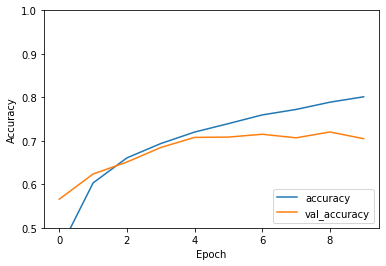

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# Bonus: TensorBoard Computation Graphs

In [18]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# The function to be traced.
@tf.function
def my_func(x, y):
  # A simple hand-rolled layer.
  return tf.nn.relu(tf.matmul(x, y))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)